In [1]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd 
import torch
from sentence_transformers import models, losses, evaluation, SentenceTransformer
import os
import json
from transformers import BertJapaneseTokenizer, BertModel
import pickle

from lightgbm import LGBMRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold

2022-11-15 18:34:19.727087: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 18:34:19.873683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 18:34:19.873704: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 18:34:19.903614: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 18:34:20.920206: W tensorflow/stream_executor/platform/de

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold


from sklearn.preprocessing import StandardScaler

from modules import meishi,wakachi
import mojimoji

In [3]:
from modules import one_hot, ShowList,makeAug, CSVfordf, sBERT_model,use_sBERT_model
from modules import label_encording, Add_class_wight

In [2]:
df = CSVfordf('CorrectedDatanew.csv')

NameError: name 'CSVfordf' is not defined

In [3]:
df.head()

NameError: name 'df' is not defined

In [11]:
#diagnosisのみ変形語
df.to_csv("CSVs/data(diagnosi).csv")

### purpose（文書）の変形 
### １sentenceBERT

In [167]:
df = pd.read_csv("CSVs/data(diagnosi).csv")

In [168]:
df=df[:50]

In [169]:
model = sBERT_model("../data/model/strf_sonoisa_sentence-bert-base-ja-mean-tokens-v232.75.10")

In [170]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 75, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (dense): Dense({'in_features': 768, 'out_features': 139, 'bias': False, 'activation_function': 'torch.nn.modules.linear.Identity'})
)

In [171]:
df = use_sBERT_model(df , model, 'CSVs/sBERT_data.csv')

### データセットsBERTに変換

In [172]:
df_sBERT=pd.read_csv("CSVs/sBERT_data.csv")
#df_ft=pd.read_csv("CSVs/ft_data.csv")

df_sBERT=df_sBERT.drop(["Unnamed: 0",'Unnamed: 0.1', 'purpose', 'diagnosis',], axis=1)
#df_ft=df_ft.drop(["Unnamed: 0", 'purpose', 'diagnosis',], axis=1)
#pd.set_option("display.max_rows", None, "display.max_columns", None)

In [173]:
df_sBERT.head()

,year,section,label,position,男,女,単純,造影,new_diagnosis,Dvec0,...,P(S)vec129,P(S)vec130,P(S)vec131,P(S)vec132,P(S)vec133,P(S)vec134,P(S)vec135,P(S)vec136,P(S)vec137,P(S)vec138
0,46,脳内,H1,胸部委任,1,0,1,0,"['脳梗塞', '急性期', '血栓性', 'ｱﾃﾛｰﾑ']",0.5450,...,-0.081758,0.549914,-0.584745,-0.159044,0.119145,0.484705,-0.699305,0.168667,-0.172199,-0.706338
1,72,脳内,H1,胸部委任,1,0,1,0,"['術後', '左鎖骨下動脈狭窄症', '冠動脈', 'ﾊﾞｲﾊﾟｽ']",0.3496,...,0.381831,-0.206590,-0.230780,-0.221049,0.785831,0.194651,-0.112709,0.330984,-0.378972,-0.148635
2,72,心外,H1,胸部委任,0,1,1,0,['鎖骨下動脈瘤'],0.2888,...,-0.303869,-0.642478,0.234565,-0.697180,0.053160,0.015407,-0.090424,0.260175,0.069848,-0.773334
3,48,腎内,A2,下肢血管,1,0,1,0,"['動脈硬化症', '閉塞性', '下肢']",0.1619,...,0.513388,0.105950,-0.577218,0.331963,0.222876,-0.084044,0.274580,0.015949,0.440825,0.473393
4,60,皮膚,A2,下肢血管,0,1,1,0,"['ﾊﾞｰｼﾞｬｰ', '四肢', '病']",0.1338,...,0.015797,-0.084961,0.381342,-0.218095,-0.474261,0.231522,-0.439021,0.719141,0.371222,0.346479


In [174]:
X,y = label_encording(df_sBERT)

In [175]:
X

,year,男,女,単純,造影,Dvec0,Dvec1,Dvec2,Dvec3,Dvec4,...,P(S)vec131,P(S)vec132,P(S)vec133,P(S)vec134,P(S)vec135,P(S)vec136,P(S)vec137,P(S)vec138,sec_lbl,pos_lbl
0,46,1,0,1,0,0.54500,0.87260,0.74460,-0.43120,0.27170,...,-0.584745,-0.159044,0.119145,0.484705,-0.699305,0.168667,-0.172199,-0.706338,10,3
1,72,1,0,1,0,0.34960,0.38280,0.53760,-0.69000,0.15860,...,-0.230780,-0.221049,0.785831,0.194651,-0.112709,0.330984,-0.378972,-0.148635,10,3
2,72,0,1,1,0,0.28880,0.33840,0.41580,-0.50500,-0.16020,...,0.234565,-0.697180,0.053160,0.015407,-0.090424,0.260175,0.069848,-0.773334,4,3
3,48,1,0,1,0,0.16190,0.09310,0.60740,-0.10920,0.11456,...,-0.577218,0.331963,0.222876,-0.084044,0.274580,0.015949,0.440825,0.473393,11,0
4,60,0,1,1,0,0.13380,0.19870,0.15780,0.01365,0.12340,...,0.381342,-0.218095,-0.474261,0.231522,-0.439021,0.719141,0.371222,0.346479,9,0
5,63,1,0,1,0,0.16190,0.09310,0.60740,-0.10920,0.11456,...,-0.175088,-0.559836,0.285337,0.198091,-0.054929,-0.054336,0.118424,-0.282190,3,0
6,68,1,0,1,0,0.16190,0.09310,0.60740,-0.10920,0.11456,...,-0.115411,-0.589803,-0.241327,0.106075,-0.333678,0.237714,-0.034025,0.345027,3,0
7,70,1,0,1,0,0.16190,0.09310,0.60740,-0.10920,0.11456,...,-0.255649,-1.101688,0.167414,0.748281,0.151704,0.177686,0.277585,-0.286840,3,0
8,71,1,0,1,0,0.16190,0.09310,0.60740,-0.10920,0.11456,...,-0.157740,-0.696135,0.856500,0.310406,0.279468,0.576931,-0.345375,-0.073949,3,0
9,72,1,0,1,0,0.16190,0.09310,0.60740,-0.10920,0.11456,...,0.091356,0.843054,0.324736,-1.280500,0.324126,-0.848279,1.602742,0.301920,3,0


In [176]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y
                                                   )

### Kfold_LBGM
#https://an-engineer-note.com/?p=312

In [38]:
# 5-fold CVモデルの学習
# 5つのモデルを保存するリストの初期化
models = []

# 学習データの数だけの数列（0行から最終行まで連番）
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=0)

categorical_features = {*sorted(['pos_lbl', 'sec_lbl'])}

In [41]:
# KFoldクラスで分割した回数だけ実行（ここでは5回）
for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    #不均衡データの重み
    w_array=Add_class_wight(X_train_cv,  y_train_cv) 
    
    # 学習用
    lgb_train = lgb.Dataset(X_train_cv, y_train_cv,
                            categorical_feature=categorical_features,
                            free_raw_data=False,
                            weight=w_array)
    # 検証用
    lgb_eval = lgb.Dataset(X_eval_cv, y_eval_cv, reference=lgb_train,
                           categorical_feature=categorical_features,
                           free_raw_data=False,
                           weight=np.ones(len(X_eval_cv)).astype('float16'))
    
    # パラメータを設定
    params = {'task': 'train',                # 学習、トレーニング ⇔　予測predict
              'boosting_type': 'gbdt',        # 勾配ブースティング
              'objective': 'multiclass',      # 目的関数：多値分類、マルチクラス分類
              'metric': 'multi_logloss',      # 分類モデルの性能を測る指標
              'num_class': 55,                 # 目的変数のクラス数
              'learning_rate': 0.02,          # 学習率（初期値0.1）
              'num_leaves': 23,               # 決定木の複雑度を調整（初期値31）
              'min_data_in_leaf': 1,          # データの最小数（初期値20）
             }
    
    # 学習
    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(params,                                   # 上記で設定したパラメータ
                      lgb_train,                                # 使用するデータセット
                      num_boost_round=1000,                     # 学習の回数
                      valid_names=['train', 'valid'],           # 学習経過で表示する名称
                      valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                      evals_result=evaluation_results,          # 学習の経過を保存
                      categorical_feature=categorical_features, # カテゴリー変数を設定
                      early_stopping_rounds=20,                 # アーリーストッピング# 学習
                      verbose_eval=-1)                          # 学習の経過の非表示
    
    # テストデータで予測する
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred_max = np.argmax(y_pred, axis=1)

    # Accuracy を計算する
    accuracy = sum(y_test == y_pred_max) / len(y_test)
    print('accuracy:', accuracy)
    
    # 学習が終わったモデルをリストに入れておく
    models.append(model) 

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.9/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is dep

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1195
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 244
[LightGBM] [Info] Start training from score -0.693188
[LightGBM] [Info] Start training from score -0.693106
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

In [50]:
models[1]

In [61]:
# テストデータで予測
y_pred = model.predict(X_test, num_iteration=models[3].best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# Accuracy の計算
accuracy = sum(y_test == y_pred_max) / len(y_test)
print('accuracy:', accuracy)

# feature importanceを表示
importance = pd.DataFrame(model.feature_importance(), index=X.columns, columns=['importance'])
display(importance)

print(classification_report(y_pred_max, y_test))

accuracy: 0.75


,importance
year,4
男,0
女,0
単純,0
造影,0
...,...
P(S)vec136,0
P(S)vec137,0
P(S)vec138,0
sec_lbl,2


              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.00      0.00      0.00         0

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
np.set_printoptions(suppress=True) 
print(y_pred)

[[0.66608403 0.33391597 0.        ]
 [0.66608403 0.33391597 0.        ]
 [0.66608403 0.33391597 0.        ]
 [0.66608403 0.33391597 0.        ]]


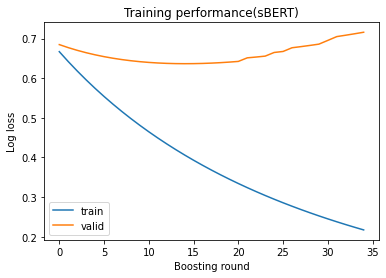

In [58]:
# 学習過程の可視化
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance(sBERT)')
plt.legend()
plt.show()

#https://potesara-tips.com/lightgbm-holdout/
#https://potesara-tips.com/lightgbm-k-fold-cross-validation/

### NN

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=ja

In [177]:
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=0)

In [178]:
list(range(len(y_train)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39]

In [179]:
y_train

array([1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 2,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [180]:
# 変換するカテゴリ変数をリストに格納
cat_cols = ['pos_lbl', 'sec_lbl']

In [182]:
#https://github.com/ghmagazine/kagglebook/blob/master/ch03/ch03-02-categorical.py
# target encoding - クロスバリデーションのfoldごとの場合
# クロスバリデーションのfoldごとにtarget encodingをやり直す
row_no_list = list(range(len(y_train)))

# KFoldクラスをインスタンス化（これを使って5分割する）
K_fold = StratifiedKFold(n_splits=5, shuffle=True,  random_state=0)

for train_cv_no, eval_cv_no in K_fold.split(row_no_list, y_train):
    # ilocで取り出す行を指定
    X_train_cv = X_train.iloc[train_cv_no, :]
    y_train_cv = pd.Series(y_train).iloc[train_cv_no]
    X_eval_cv = X_train.iloc[eval_cv_no, :]
    y_eval_cv = pd.Series(y_train).iloc[eval_cv_no]
    

    
    # 変数をループしてtarget encoding
    for c in cat_cols:
        # 学習データ全体で各カテゴリにおけるtargetの平均を計算
        data_tmp = pd.DataFrame({c: X_train_cv[c], 'target': y_train_cv})
        target_mean = data_tmp.groupby(c)['target'].mean()
        # バリデーションデータのカテゴリを置換
        va_x.loc[:, c] = va_x[c].map(target_mean)
        
        
        # 学習データの変換後の値を格納する配列を準備
        tmp = np.repeat(np.nan, tr_x.shape[0])
        
        # 学習データを分割(target encording)
        kf = KFold(n_splits=4, shuffle=True, random_state=72)
        
        #X_train_cv[:, c] = tmp
        
        
    #print(X_train_cv)
        
        


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [162]:
X_train

,year,男,単純,造影,Dvec0,Dvec1,Dvec2,Dvec3,Dvec4,Dvec5,...,P(S)vec131,P(S)vec132,P(S)vec133,P(S)vec134,P(S)vec135,P(S)vec136,P(S)vec137,P(S)vec138,sec_lbl,pos_lbl
14,77,1,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,0.33570,...,0.236580,-0.528902,0.145212,0.432174,0.378884,-0.031530,0.533770,-0.575563,1,0
6,68,1,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,0.33570,...,-0.115411,-0.589803,-0.241328,0.106076,-0.333678,0.237714,-0.034026,0.345027,1,0
19,85,1,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,0.33570,...,-0.175613,-0.503233,0.968117,-0.286183,-0.173168,0.204911,0.255509,0.000013,0,0
11,76,1,1,0,0.05320,0.12146,0.3630,-0.44140,0.06790,-0.28080,...,0.481526,0.767192,-0.474760,0.013001,-0.388784,-0.042614,-0.246384,-0.156347,2,0
5,63,1,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,0.33570,...,-0.175088,-0.559836,0.285337,0.198091,-0.054929,-0.054336,0.118424,-0.282190,1,0
2,72,0,1,0,0.28880,0.33840,0.4158,-0.50500,-0.16020,0.11030,...,0.234565,-0.697180,0.053160,0.015407,-0.090424,0.260175,0.069848,-0.773334,2,1
4,60,0,1,0,0.13380,0.19870,0.1578,0.01365,0.12340,0.02562,...,0.381342,-0.218095,-0.474261,0.231522,-0.439021,0.719141,0.371222,0.346479,3,0
12,76,1,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,0.33570,...,-0.322153,-0.211225,0.860618,0.160621,0.404375,0.145034,-0.194606,-0.727281,1,0
16,79,1,1,0,0.15010,0.19790,0.4950,-0.15990,0.04590,0.21440,...,0.100167,-0.263684,0.251756,0.034718,0.159901,0.164445,0.418868,-0.178246,2,0
3,48,1,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,0.33570,...,-0.577218,0.331963,0.222876,-0.084044,0.274580,0.015949,0.440825,0.473393,5,0


In [62]:
import tensorflow as tf
from tensorflow import keras

In [76]:
X

,year,男,女,単純,造影,Dvec0,Dvec1,Dvec2,Dvec3,Dvec4,...,P(S)vec131,P(S)vec132,P(S)vec133,P(S)vec134,P(S)vec135,P(S)vec136,P(S)vec137,P(S)vec138,sec_lbl,pos_lbl
0,46,1,0,1,0,0.54500,0.87260,0.7446,-0.43120,0.27170,...,-0.584746,-0.159044,0.119145,0.484705,-0.699305,0.168667,-0.172199,-0.706338,4,1
1,72,1,0,1,0,0.34960,0.38280,0.5376,-0.69000,0.15860,...,-0.230780,-0.221049,0.785830,0.194651,-0.112709,0.330984,-0.378972,-0.148635,4,1
2,72,0,1,1,0,0.28880,0.33840,0.4158,-0.50500,-0.16020,...,0.234565,-0.697180,0.053160,0.015407,-0.090424,0.260175,0.069848,-0.773334,2,1
3,48,1,0,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,...,-0.577218,0.331963,0.222876,-0.084044,0.274580,0.015949,0.440825,0.473393,5,0
4,60,0,1,1,0,0.13380,0.19870,0.1578,0.01365,0.12340,...,0.381342,-0.218095,-0.474261,0.231522,-0.439021,0.719141,0.371222,0.346479,3,0
5,63,1,0,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,...,-0.175088,-0.559836,0.285337,0.198091,-0.054929,-0.054336,0.118424,-0.282190,1,0
6,68,1,0,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,...,-0.115411,-0.589803,-0.241328,0.106076,-0.333678,0.237714,-0.034026,0.345027,1,0
7,70,1,0,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,...,-0.255650,-1.101688,0.167413,0.748281,0.151704,0.177685,0.277586,-0.286841,1,0
8,71,1,0,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,...,-0.157740,-0.696135,0.856500,0.310406,0.279468,0.576931,-0.345375,-0.073949,1,0
9,72,1,0,1,0,0.16190,0.09310,0.6074,-0.10920,0.11456,...,0.091356,0.843055,0.324736,-1.280500,0.324126,-0.848279,1.602742,0.301920,1,0


In [75]:
y

array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [80]:
import tensorflow as tf
from tensorflow import keras

In [78]:
# Use a utility from sklearn to split and shuffle your dataset.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y
                                                   )

In [94]:
#sklearn の StandardScaler を使用して入力特徴を正規化します。これで平均は 0、標準偏差は 1 に設定されます。

#注意: StandardScalerはtrain_featuresを使用する場合にのみ適合し、モデルが検証セットやテストセットでピークを迎えることがないようにします。
scaler = StandardScaler()
train_features = scaler.fit_transform(X_train)
test_features = scaler.transform(X_test)

train_features = np.clip(train_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [83]:
train_features

array([[ 0.61582129,  0.37796447,  0.        , ..., -0.94564129,
        -0.64168895, -0.37796447],
       [-0.22076612,  0.37796447,  0.        , ...,  1.35449416,
        -0.64168895, -0.37796447],
       [ 1.35945454,  0.37796447,  0.        , ...,  0.49245998,
        -1.37504775, -0.37796447],
       ...,
       [ 0.61582129,  0.37796447,  0.        , ...,  0.54036511,
        -0.64168895, -0.37796447],
       [-2.26575757,  0.37796447,  0.        , ..., -1.27238752,
         1.55838744,  2.64575131],
       [ 0.98763791,  0.37796447,  0.        , ..., -0.67960387,
        -0.64168895, -0.37796447]])

In [87]:
print('Training labels shape:', y_train.shape)
print('Test labels shape:', y_test.shape)

print('Training features shape:', train_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (16,)
Test labels shape: (4,)
Training features shape: (16, 245)
Test features shape: (4, 245)


In [88]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [105]:
def make_model(metrics=METRICS, output_bias=None):
      if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
      model = keras.Sequential([
          keras.layers.Dense(
              16, activation='relu',
              input_shape=(train_features.shape[-1],)),
          keras.layers.Dropout(0.5),
          keras.layers.Dense(1, activation='sigmoid',
                             bias_initializer=output_bias),
      ])

      model.compile(
          optimizer=keras.optimizers.Adam(learning_rate=1e-3),
          loss=keras.losses.BinaryCrossentropy(),
          metrics=metrics)

      return model

In [106]:
EPOCHS = 10 #100
BATCH_SIZE = 3 #2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [107]:
nnmodel = make_model()
nnmodel.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 16)                3936      
                                                                 
 dropout_9 (Dropout)         (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,953
Trainable params: 3,953
Non-trainable params: 0
_________________________________________________________________


In [103]:
nnmodel.predict(train_features[:10])

1/1 [==============================] - 1s 1s/step


array([[0.6827062 ],
       [0.8306404 ],
       [0.80636317],
       [0.9999294 ],
       [0.798043  ],
       [0.9939438 ],
       [0.6381198 ],
       [0.74483323],
       [0.6838714 ],
       [0.9020845 ]], dtype=float32)

In [111]:
results = nnmodel.evaluate(train_features, y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.5402


In [ ]:
Add_class_wight(train_features, y_train)

array([0.5713, 0.5713, 0.5713, 0.5713, 0.5713, 4.    , 0.5713, 0.5713,
       0.5713, 0.5713, 0.5713, 0.5713, 0.5713, 0.5713, 4.    , 0.5713],
      dtype=float16)

In [121]:
weighted_model = make_model()


weighted_history = weighted_model.fit(
    train_features,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(test_features, y_test),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/10
6/6 [==============================] - 2s 125ms/step - loss: 1.2586 - tp: 0.0000e+00 - fp: 6.0000 - tn: 22.0000 - fn: 4.0000 - accuracy: 0.6875 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4375 - prc: 0.1124 - val_loss: 0.9546 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3.0000 - val_fn: 1.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.1370
Epoch 2/10
6/6 [==============================] - 0s 12ms/step - loss: 1.0895 - tp: 0.0000e+00 - fp: 2.0000 - tn: 12.0000 - fn: 2.0000 - accuracy: 0.7500 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3929 - prc: 0.0973 - val_loss: 0.8160 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 3.0000 - val_fn: 1.0000 - val_accuracy: 0.7500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 0.1370
Epoch 3/10
6/6 [==============================] - 0s 11ms/step - loss: 0.7080 - tp: 0.0000e+00 - fp: 2.0000 - tn: 12.0000 -

In [112]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

In [113]:
plot_metrics(baseline_history)

NameError: name 'baseline_history' is not defined